In [1]:
# Importing necessary libraries
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
#from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
uploaded = files.upload()

Saving survival_clean.csv to survival_clean.csv


In [3]:
import pandas as pd
df_full = pd.read_csv('survival_clean.csv')

In [4]:
# Assuming df is your DataFrame and 'target' is your target variable
X = df_full.drop('hospital_death', axis=1)  # Drop the target column
y = df_full['hospital_death']


In [5]:
df_full_categorical = ['apache_3j_bodysystem', 'apache_2_bodysystem', 'ethnicity',
                       'icu_admit_source', 'gender', 'icu_stay_type', 'icu_type' ]

df_full_binary = ['elective_surgery', 'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache',
                  'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia',
                  'lymphoma', 'solid_tumor_with_metastasis', 'apache_post_operative']

df_full_multicat = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

df_full_numeric = ['age', 'bmi', 'height', 'weight', 'pre_icu_los_days','heart_rate_apache', 'map_apache','resprate_apache',
                   'temp_apache', 'd1_potassium_min', 'd1_potassium_max', 'h1_mbp_max',
                   'h1_mbp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_sysbp_max','h1_sysbp_min','d1_glucose_min',
                   'd1_glucose_max','h1_resprate_max','h1_resprate_min','h1_heartrate_max','h1_heartrate_min',
                   'd1_temp_max','d1_temp_min','d1_diasbp_max','d1_diasbp_min','d1_resprate_min','d1_resprate_max',
                   'd1_spo2_min','d1_spo2_max','h1_spo2_max','h1_spo2_min','d1_mbp_min','d1_mbp_max','d1_sysbp_min',
                   'd1_sysbp_max','d1_heartrate_max','d1_heartrate_min', 'apache_4a_hospital_death_prob',
                   'apache_4a_icu_death_prob']


In [6]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.4 MB/s eta 0:00:00


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
categorical_cols = df_full_categorical
binary_cols = df_full_binary
multicat_cols = df_full_multicat
numeric_cols = df_full_numeric

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# 75% training , 25% test

# Define preprocessing for SMOTE (encode categorical variables)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('multi', 'passthrough', multicat_cols),  # Assuming these are already encoded as numbers
        ('binary', 'passthrough', binary_cols),   # Assuming these are binary (0/1)
        ('num', StandardScaler(), numeric_cols)
    ]
)

# Transform X_train for SMOTE
X_train_processed = preprocessor.fit_transform(X_train)

# Apply SMOTE on the preprocessed training data
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

# Convert X_resampled back to DataFrame for inspection (optional)
X_resampled_df = pd.DataFrame(X_resampled, columns=preprocessor.get_feature_names_out())

# Check class distribution before and after SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())
print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class distribution before SMOTE:
hospital_death
0    62823
1     5961
Name: count, dtype: int64

Class distribution after SMOTE:
hospital_death
0    62823
1    31411
Name: count, dtype: int64


In [8]:
print("Shape of X_resampled (Training Data After SMOTE):", X_resampled_df.shape)
print("Number of rows in X_resampled:", X_resampled_df.shape[0])
print("Number of columns in X_resampled:", X_resampled_df.shape[1])

# Confirm the shape of the target variable after resampling
print("Number of rows in y_resampled:", len(y_resampled))

Shape of X_resampled (Training Data After SMOTE): (94234, 96)
Number of rows in X_resampled: 94234
Number of columns in X_resampled: 96
Number of rows in y_resampled: 94234


In [9]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define parameter grid with refined ranges
dt_params = {
    'max_depth': range(5, 26, 2),               # Depths from 10 to 41 in increments of 3
    'min_samples_split': range(50, 201, 50),     # Min samples from 50 to 200 in increments of 50
    'max_leaf_nodes': range(20, 101, 20)         # Max leaf nodes from 20 to 100 in increments of 20
}

# Initialize Decision Tree Classifier with balanced class weights and consistent random state
opt_tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Set up GridSearchCV with 5-fold cross-validation, using accuracy as the scoring metric
grid_tree = GridSearchCV(
    estimator=opt_tree,
    param_grid=dt_params,
    cv=5,                       # 5-fold cross-validation
    scoring='f1_weighted',
    n_jobs=-1                    # Use all available cores for efficiency
)

# Fit the grid search on the resampled training data
grid_tree.fit(X_resampled, y_resampled)

# Output the best parameters and corresponding cross-validation accuracy
print("Best Parameters:", grid_tree.best_params_)
print("Best Cross-Validation Accuracy:", grid_tree.best_score_)

# Retrieve the best model from GridSearchCV
best_tree = grid_tree.best_estimator_

# Evaluate model performance on training set
y_train_pred = best_tree.predict(X_resampled)
train_accuracy = accuracy_score(y_resampled, y_train_pred)
print("\nTrain Accuracy Score:", train_accuracy)

# Process test set with the same preprocessor (without resampling)
X_test_processed = preprocessor.transform(X_test)

# Predict and evaluate on the test set
y_test_pred = best_tree.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nTest Accuracy Score:", test_accuracy)

# Confusion Matrix and Classification Report on test set
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Optional: Additional metrics for better insight into class imbalance handling
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')
print("\nPrecision (Class 1):", precision)
print("Recall (Class 1):", recall)
print("F1-Score (Class 1):", fscore)


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 21, 'max_leaf_nodes': 100, 'min_samples_split': 100}
Best Cross-Validation Accuracy: 0.8924838608941534

Train Accuracy Score: 0.9014474605768619

Test Accuracy Score: 0.8728684199049239

Confusion Matrix:
 [[18771  2204]
 [  711  1243]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93     20975
           1       0.36      0.64      0.46      1954

    accuracy                           0.87     22929
   macro avg       0.66      0.77      0.69     22929
weighted avg       0.91      0.87      0.89     22929


Precision (Class 1): 0.36060342326660866
Recall (Class 1): 0.6361310133060389
F1-Score (Class 1): 0.46028513238289204


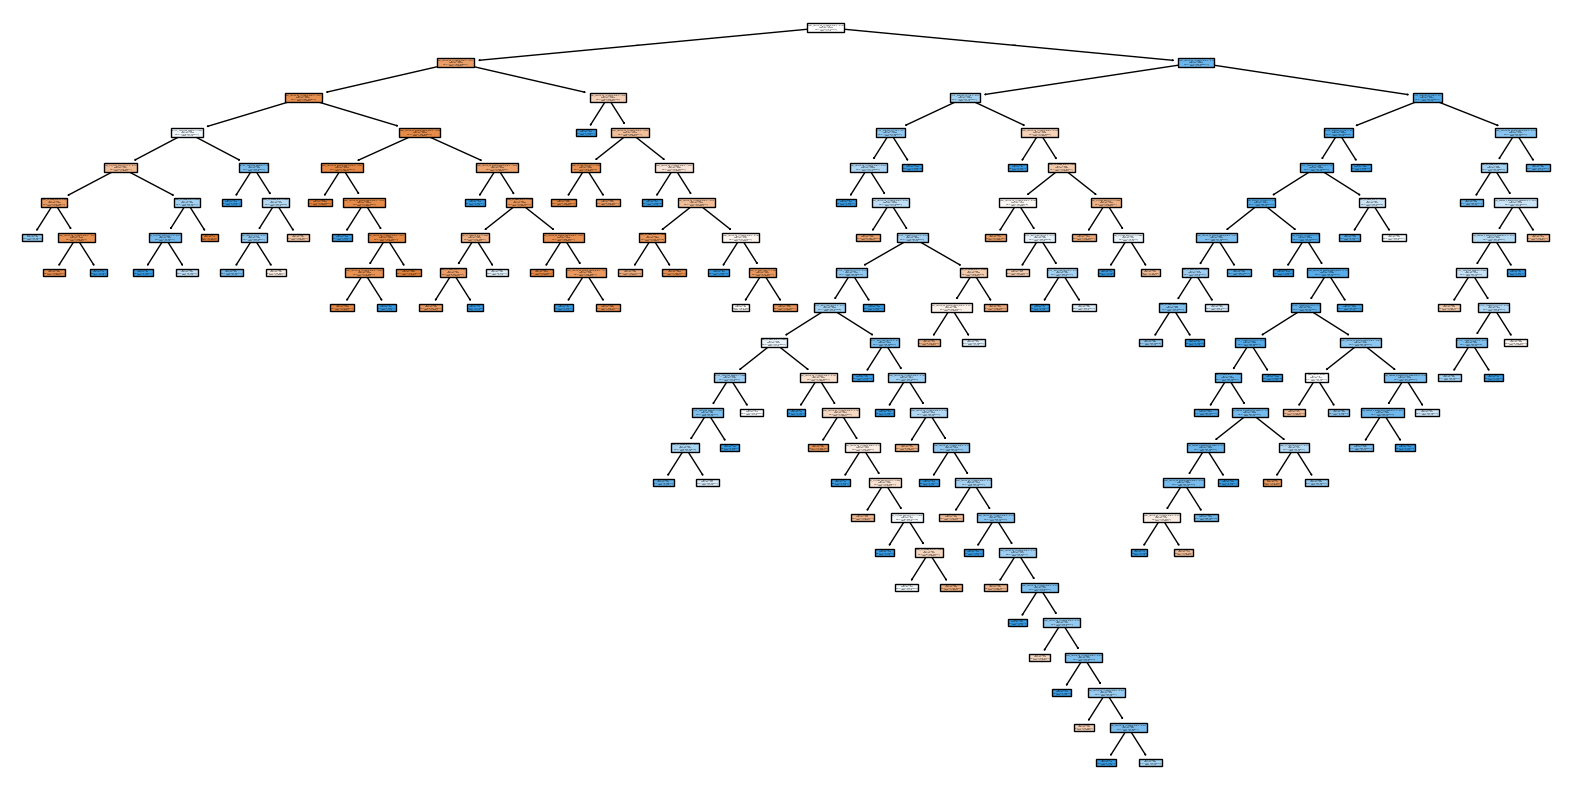

In [10]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Retrieve the best estimator (the best decision tree model from Grid Search)
best_tree = grid_tree.best_estimator_

# Set up the plot
plt.figure(figsize=(20, 10))  # Adjust the figure size for readability

# Plot the tree
plot_tree(
    best_tree,
    filled=True,                      # Colors the nodes by class
    feature_names=preprocessor.get_feature_names_out(),  # Use feature names from preprocessing
    class_names=['No Death', 'Death'] # Replace with appropriate class names
                     # Display only the top levels for readability; change as needed
)

# Show the plot
plt.show()

In [11]:
import pandas as pd

# Retrieve the best estimator from GridSearchCV
best_tree = grid_tree.best_estimator_

# Get feature importances from the best model
feature_importances = best_tree.feature_importances_

# Create a DataFrame to display feature names with their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display the top features
print(feature_importance_df)

                                            Feature  Importance
0                     num__apache_4a_icu_death_prob    0.820677
1                num__apache_4a_hospital_death_prob    0.046209
2                         binary__diabetes_mellitus    0.037679
3                          binary__intubated_apache    0.022090
4                          multi__gcs_verbal_apache    0.013076
5                         binary__ventilated_apache    0.012122
6                                  num__d1_spo2_min    0.006956
7                          cat__ethnicity_Caucasian    0.006270
8                                   num__d1_mbp_min    0.004867
9                     binary__apache_post_operative    0.004567
10                      cat__icu_admit_source_Floor    0.004260
11                       cat__icu_type_Med-Surg ICU    0.003923
12                                num__d1_sysbp_min    0.003200
13             cat__apache_2_bodysystem_Respiratory    0.002488
14                 cat__apache_3j_bodysy

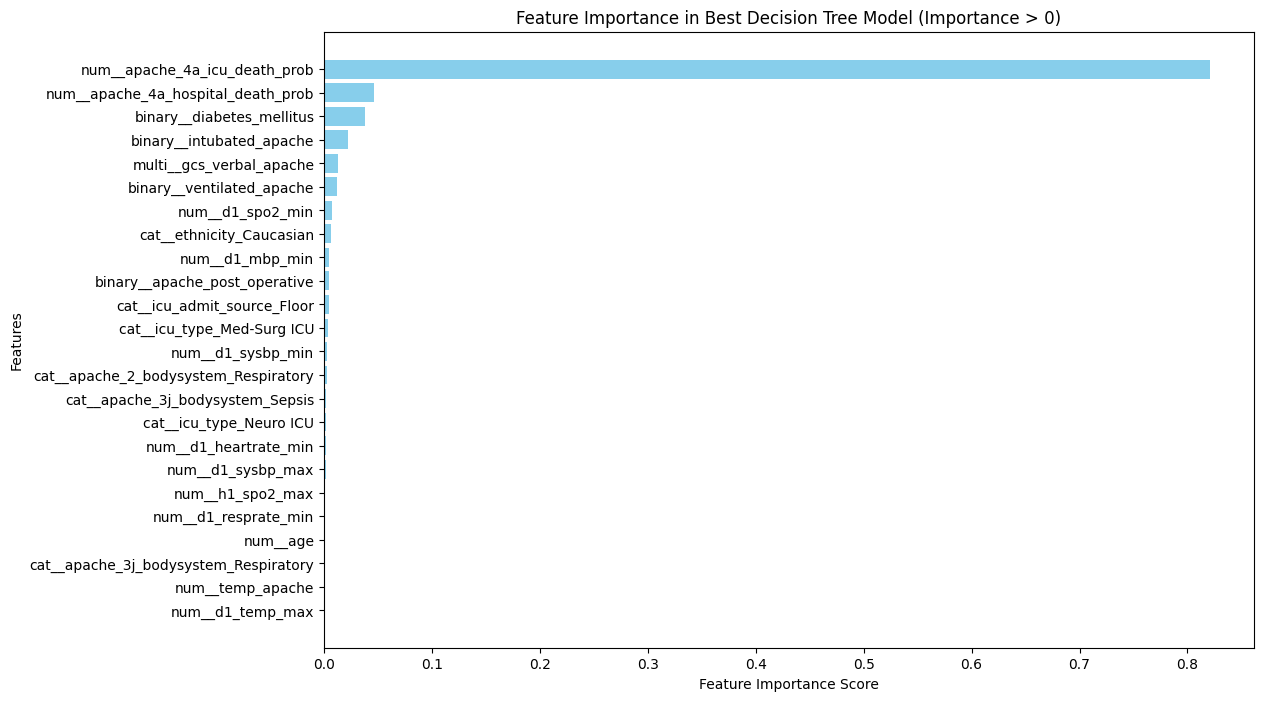

In [12]:
import matplotlib.pyplot as plt

# Filter to include only features with importance greater than 0
important_features_df = feature_importance_df[feature_importance_df['Importance'] > 0]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(important_features_df['Feature'], important_features_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Best Decision Tree Model (Importance > 0)")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Assuming X_resampled and y_resampled are the resampled data from SMOTE + Tomek Links
# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Define scoring metric focused on F1 for the minority class (class 1)
f1_minority = make_scorer(f1_score, pos_label=1)

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=f1_minority,  # Focuses on F1 for class 1
    cv=cv,
    n_jobs=-1,  # Use all available cores
    verbose=2
)

In [15]:
grid_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=1),
             verbose=2)

In [16]:
# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score for minority class: ", grid_search.best_score_)

# Predict on the original test set
best_rf = grid_search.best_estimator_
# Transform X_test using the same preprocessor pipeline
X_test_processed = preprocessor.transform(X_test)

# Now, use the transformed test set for prediction
y_pred = best_rf.predict(X_test_processed)

# Evaluate the performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 score for minority class:  0.9191961272026097
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     20975
           1       0.56      0.43      0.49      1954

    accuracy                           0.92     22929
   macro avg       0.76      0.70      0.72     22929
weighted avg       0.92      0.92      0.92     22929



In [17]:
# Evaluate model performance on training set
y_train_pred_rf = best_rf.predict(X_resampled)
train_accuracy_rf = accuracy_score(y_resampled, y_train_pred_rf)
print("\nTrain Accuracy Score:", train_accuracy_rf)

# Process test set with the same preprocessor (without resampling)
X_test_processed = preprocessor.transform(X_test)

# Predict and evaluate on the test set
y_test_pred_rf = best_rf.predict(X_test_processed)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print("\nTest Accuracy Score:", test_accuracy_rf)


Train Accuracy Score: 0.997166627756436

Test Accuracy Score: 0.9232413101312748


In [18]:
# Get feature importances from the best Random Forest model
feature_importances = best_rf.feature_importances_

# Create a DataFrame to display feature names with their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display the top features
print(feature_importance_df)

                                            Feature  Importance
0                num__apache_4a_hospital_death_prob    0.118012
1                     num__apache_4a_icu_death_prob    0.112870
2                         binary__ventilated_apache    0.062734
3                          multi__gcs_verbal_apache    0.032191
4                           multi__gcs_motor_apache    0.029152
5                  cat__apache_3j_bodysystem_Sepsis    0.028535
6                          binary__intubated_apache    0.028023
7                            multi__gcs_eyes_apache    0.026711
8                                 num__d1_sysbp_min    0.023043
9                       cat__icu_admit_source_Floor    0.021807
10                                 num__d1_spo2_min    0.020061
11                       cat__icu_type_Med-Surg ICU    0.019309
12                                         num__age    0.015298
13                                 num__d1_temp_min    0.014026
14                                  num_

In [19]:
# Filter to include only features with importance greater than 0
# Filter to include only features with importance greater than 0 and round the values

feature_importance_df['Importance'] = feature_importance_df['Importance'].round(2)

top_n = 25
top_features_df = feature_importance_df.head(top_n)
top_features_df

Feature  Importance
0                num__apache_4a_hospital_death_prob        0.12
1                     num__apache_4a_icu_death_prob        0.11
2                         binary__ventilated_apache        0.06
3                          multi__gcs_verbal_apache        0.03
4                           multi__gcs_motor_apache        0.03
5                  cat__apache_3j_bodysystem_Sepsis        0.03
6                          binary__intubated_apache        0.03
7                            multi__gcs_eyes_apache        0.03
8                                 num__d1_sysbp_min        0.02
9                       cat__icu_admit_source_Floor        0.02
10                                 num__d1_spo2_min        0.02
11                       cat__icu_type_Med-Surg ICU        0.02
12                                         num__age        0.02
13                                 num__d1_temp_min        0.01
14                                  num__d1_mbp_min        0.01
15                             num__d1_resprate_max        0.01
16                        binary__diabetes_mellitus        0.01
17                            num__d1_heartrate_max        0.01
18                    binary__apache_post_operative        0.01
19  cat__icu_admit_source_Operating Room / Recovery        0.01
20                               num__d1_diasbp_min        0.01
21                             num__resprate_apache        0.01
22                         binary__elective_surgery        0.01
23                                 num__temp_apache        0.01
24                            num__pre_icu_los_days        0.01

In [20]:
# Filter to include only features with importance greater than 0
# Filter to include only features with importance greater than 0 and round the values

feature_importance_df['Importance'] = feature_importance_df['Importance'].round(2)

top_n = 25
top_features_df = feature_importance_df.head(top_n)
top_features_df

Feature  Importance
0                num__apache_4a_hospital_death_prob        0.12
1                     num__apache_4a_icu_death_prob        0.11
2                         binary__ventilated_apache        0.06
3                          multi__gcs_verbal_apache        0.03
4                           multi__gcs_motor_apache        0.03
5                  cat__apache_3j_bodysystem_Sepsis        0.03
6                          binary__intubated_apache        0.03
7                            multi__gcs_eyes_apache        0.03
8                                 num__d1_sysbp_min        0.02
9                       cat__icu_admit_source_Floor        0.02
10                                 num__d1_spo2_min        0.02
11                       cat__icu_type_Med-Surg ICU        0.02
12                                         num__age        0.02
13                                 num__d1_temp_min        0.01
14                                  num__d1_mbp_min        0.01
15                             num__d1_resprate_max        0.01
16                        binary__diabetes_mellitus        0.01
17                            num__d1_heartrate_max        0.01
18                    binary__apache_post_operative        0.01
19  cat__icu_admit_source_Operating Room / Recovery        0.01
20                               num__d1_diasbp_min        0.01
21                             num__resprate_apache        0.01
22                         binary__elective_surgery        0.01
23                                 num__temp_apache        0.01
24                            num__pre_icu_los_days        0.01

In [21]:
import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest (Importance > 0)")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# define function
knn = KNeighborsClassifier()
param_knn = { 'n_neighbors': range(3, 40, 3)}

# apply grid search:
grid_knn = GridSearchCV(knn, param_knn, cv = 5)
grid_knn.fit(X_resampled, y_resampled)

print(grid_knn.best_params_)
print(grid_knn.best_score_)



from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report

best_n_neighbors = grid_knn.best_params_['n_neighbors']

# Initialize and fit KNN with the best parameters
knn_best = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_best.fit(X_resampled, y_resampled)

# Predict on the original test set
y_pred = knn_best.predict(X_test_processed)

# Calculate F1 scores
# Overall F1 score for both classes (averaged)
overall_f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for imbalance
print("Overall F1 Score (weighted):", overall_f1)

# F1 score for each class
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
print("F1 Score for Class 0:", f1_class_0)
print("F1 Score for Class 1:", f1_class_1)

# Alternatively, print a full classification report to see precision, recall, and F1 for each class
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_neighbors': 6}
0.8881508394358744
Overall F1 Score (weighted): 0.8534129259971388
F1 Score for Class 0: 0.8987530667476035
F1 Score for Class 1: 0.3667141275114697

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     20975
           1       0.27      0.59      0.37      1954

    accuracy                           0.83     22929
   macro avg       0.61      0.72      0.63     22929
weighted avg       0.90      0.83      0.85     22929



In [23]:
# Evaluate model performance on training set
y_train_pred_knn = knn_best.predict(X_resampled)
train_accuracy_knn = accuracy_score(y_resampled, y_train_pred_knn)
print("\nTrain Accuracy Score:", train_accuracy_knn)

# Process test set with the same preprocessor (without resampling)
X_test_processed = preprocessor.transform(X_test)

# Predict and evaluate on the test set
y_test_pred_knn = knn_best.predict(X_test_processed)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print("\nTest Accuracy Score:", test_accuracy_knn)


Train Accuracy Score: 0.9236050682343953

Test Accuracy Score: 0.825417593440621


In [24]:
# List of column names excluding importance scores
top_features = [
    'num__apache_4a_hospital_death_prob', 'num__apache_4a_icu_death_prob', 'binary__ventilated_apache',
    'multi__gcs_verbal_apache', 'multi__gcs_motor_apache', 'cat__apache_3j_bodysystem_Sepsis',
    'binary__intubated_apache', 'multi__gcs_eyes_apache', 'num__d1_sysbp_min',
    'cat__icu_admit_source_Floor', 'num__d1_spo2_min', 'cat__icu_type_Med-Surg ICU',
    'num__age', 'num__d1_temp_min', 'num__d1_mbp_min', 'num__d1_resprate_max',
    'binary__diabetes_mellitus', 'num__d1_heartrate_max', 'binary__apache_post_operative',
    'cat__icu_admit_source_Operating Room / Recovery', 'num__d1_diasbp_min', 'num__resprate_apache', 'binary__elective_surgery','num__temp_apache','num__pre_icu_los_days'
]

# Display the list for verification
print(top_features)


['num__apache_4a_hospital_death_prob', 'num__apache_4a_icu_death_prob', 'binary__ventilated_apache', 'multi__gcs_verbal_apache', 'multi__gcs_motor_apache', 'cat__apache_3j_bodysystem_Sepsis', 'binary__intubated_apache', 'multi__gcs_eyes_apache', 'num__d1_sysbp_min', 'cat__icu_admit_source_Floor', 'num__d1_spo2_min', 'cat__icu_type_Med-Surg ICU', 'num__age', 'num__d1_temp_min', 'num__d1_mbp_min', 'num__d1_resprate_max', 'binary__diabetes_mellitus', 'num__d1_heartrate_max', 'binary__apache_post_operative', 'cat__icu_admit_source_Operating Room / Recovery', 'num__d1_diasbp_min', 'num__resprate_apache', 'binary__elective_surgery', 'num__temp_apache', 'num__pre_icu_los_days']


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Convert X_resampled back to DataFrame and filter for the top 25 features
X_resampled_df = pd.DataFrame(X_resampled, columns=preprocessor.get_feature_names_out())
X_resampled_df = X_resampled_df[top_features]

# Step 4: Transform X_test without SMOTE and select only the top 25 features
X_test_processed = preprocessor.transform(X_test)
X_test_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())
X_test_df = X_test_df[top_features]

# Step 5: Set up Logistic Regression with GridSearchCV
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=500)
param_grid = {
'C': [0.01, 0.1, 1, 10, 100],
'penalty': ['l1', 'l2'],
'solver': ['liblinear', 'saga'],
'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}
grid_search = GridSearchCV(log_reg, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2)

# Step 6: Fit GridSearchCV on the resampled training data with selected features
grid_search.fit(X_resampled_df, y_resampled)

# Step 7: Evaluate the best model on the test set
best_log_reg = grid_search.best_estimator_
y_test_pred = best_log_reg.predict(X_test_df)

# Predict on the test set
y_test_pred = best_log_reg.predict(X_test_df)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print("Model Accuracy on Test Set:", accuracy)
print("Best parameters for Logistic Regression:", grid_search.best_params_)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Model Accuracy on Test Set: 0.7844650878799774
Best parameters for Logistic Regression: {'C': 0.01, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'liblinear'}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     20975
           1       0.25      0.77      0.38      1954

    accuracy                           0.78     22929
   macro avg       0.61      0.78      0.62     22929
weighted avg       0.91      0.78      0.83     22929

